# Analysis of Auction mechanisms

In [1]:
from __future__ import annotations

import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import json
from typing import List

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.extra.io import save_plot

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

In [2]:
# results_filename = "../data/auctions_paper_r_t40_s8_dt07-11_23-52-11.json"
results_filename = '../data/auctions_paper_r_t30_s6_dt07-14_15-07-39.json'

with open(results_filename) as file:
    results_data = json.load(file)

In [3]:
auction_results = {}
for model_results in results_data:
    for auction, auction_result in model_results.items():
        if auction == 'model':
            continue
        if auction in auction_results:
            auction_results[auction].append(auction_result)
        else:
            auction_results[auction] = [auction_result]
            
print(f'Number of algorithms: {len(auction_results)}')

Number of algorithms: 21


## Auction results

In [4]:
auction_avg_results = []
for algorithm, results in auction_results.items():
    auction_avg_results.append([
        algorithm,
        [r['social welfare'] for r in results],
        [r['social welfare percent'] for r in results],
        [r['percentage tasks allocated'] for r in results],
        [r['total revenue'] for r in results],
        [r['solve time'] for r in results],
        [task_price for r in results for task_price in r['task prices'].values()],
        np.mean([r['social welfare'] for r in results]),
        np.mean([r['total revenue'] for r in results])        
    ])
    
auction_df = pd.DataFrame(auction_avg_results, columns=[
    'name', 'social welfare', 'social welfare percent', 'percentage tasks allocated', 'revenue', 
    'solve time', 'task prices', 'avg social welfare', 'avg revenue'])
auction_df = auction_df.sort_values(by='avg social welfare', ascending=False)

In [5]:
cva_algos_df = auction_df[auction_df['name'].str.contains('Critical Value Auction')]
cva_algo = auction_df.iloc[cva_algos_df['avg social welfare'].idxmax()]['name']

Text(0.5, 1.0, 'Solve Time')

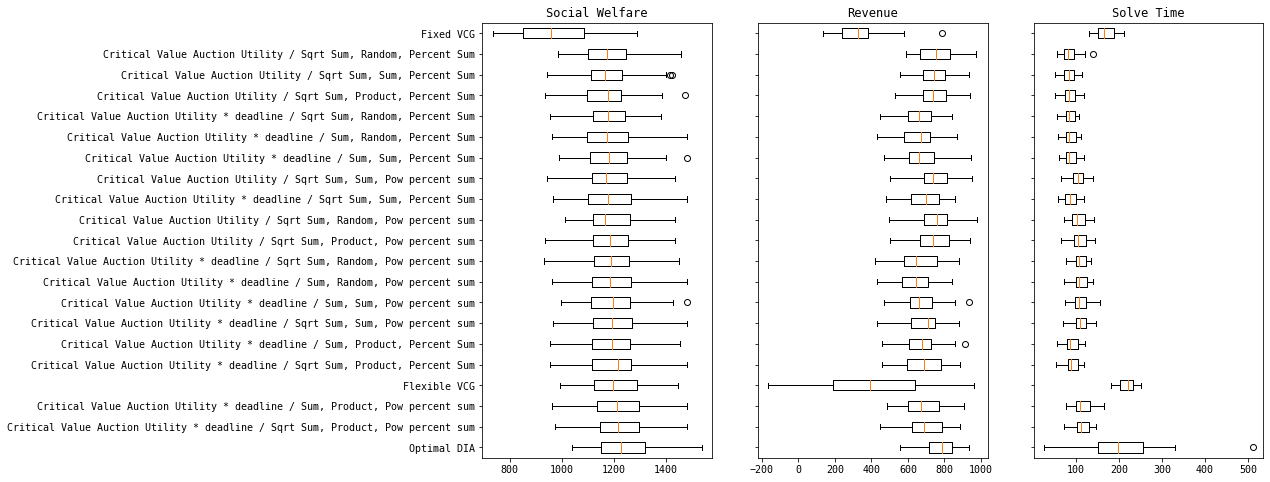

In [6]:
system_fig, (ax_sw, ax_rev, ax_st) = plt.subplots(1, 3, figsize=(14,8))
ax_sw.boxplot(auction_df['social welfare'], vert=False)
ax_sw.set_yticklabels(auction_df['name'])
ax_sw.set_title('Social Welfare')

ax_rev.boxplot(auction_df['revenue'], vert=False)
plt.setp(ax_rev.get_yticklabels(), visible=False)
ax_rev.set_title('Revenue')

ax_st.boxplot(auction_df['solve time'], vert=False)
plt.setp(ax_st.get_yticklabels(), visible=False)
ax_st.set_title('Solve Time')

## Algorithm Task Prices

Text(0.5, 1.0, 'Task Price Distribution')

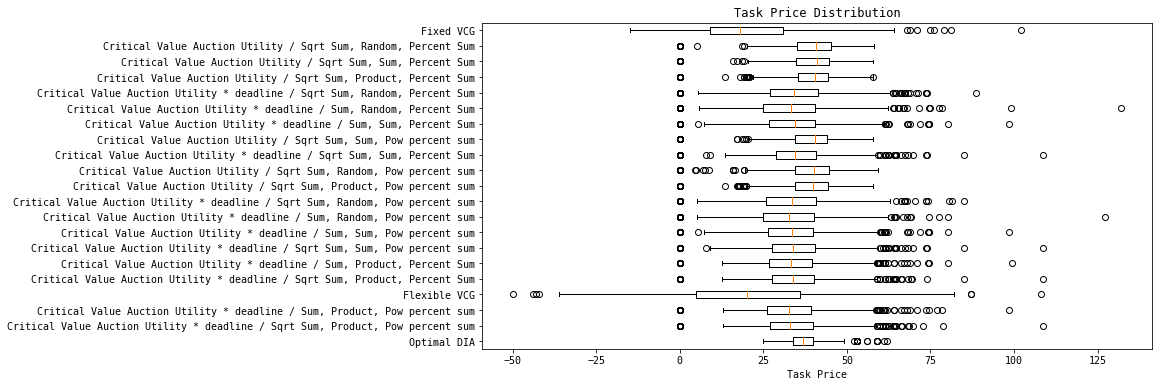

In [7]:
task_price_box_fig, ax_box = plt.subplots(figsize=(12, 6))
ax_box.boxplot(auction_df['task prices'], vert=False)
ax_box.set_yticklabels(auction_df['name'])
ax_box.set_xlabel('Task Price')
ax_box.set_title('Task Price Distribution')

## Task value and price distributions

Text(0.5, 1.0, 'CVA Task Price Distribution')

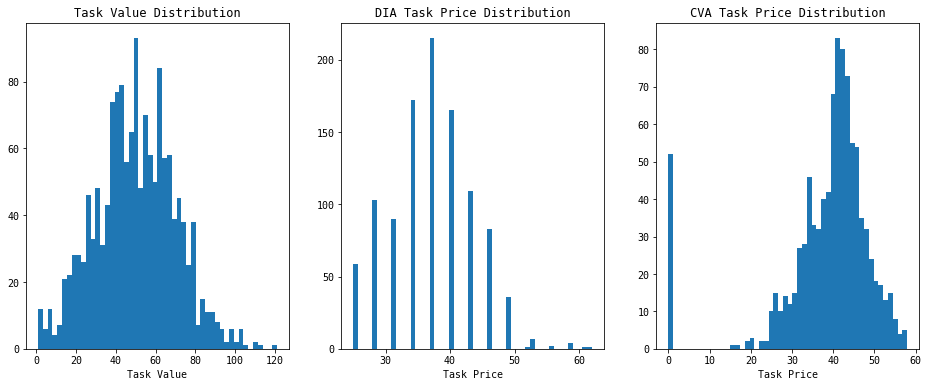

In [8]:
task_price_box_fig, (ax_value_hist, ax_dia_hist, ax_cva_dist) = plt.subplots(1, 3, figsize=(16, 6))

task_values = [task['value'] for result in results_data for task in result['model']['tasks']]
ax_value_hist.hist(task_values, bins=50)
ax_value_hist.set_xlabel('Task Value')
ax_value_hist.set_title('Task Value Distribution')

ax_dia_hist.hist(auction_df[auction_df['name'] == 'Optimal DIA']['task prices'], bins=50)
ax_dia_hist.set_xlabel('Task Price')
ax_dia_hist.set_title('DIA Task Price Distribution')

ax_cva_dist.hist(auction_df[auction_df['name'] == cva_algo]['task prices'], bins=50)
ax_cva_dist.set_xlabel('Task Price')
ax_cva_dist.set_title('CVA Task Price Distribution')

## DIA vs CVA Price difference

Text(0.5, 1.0, 'CVA Value - Price Difference')

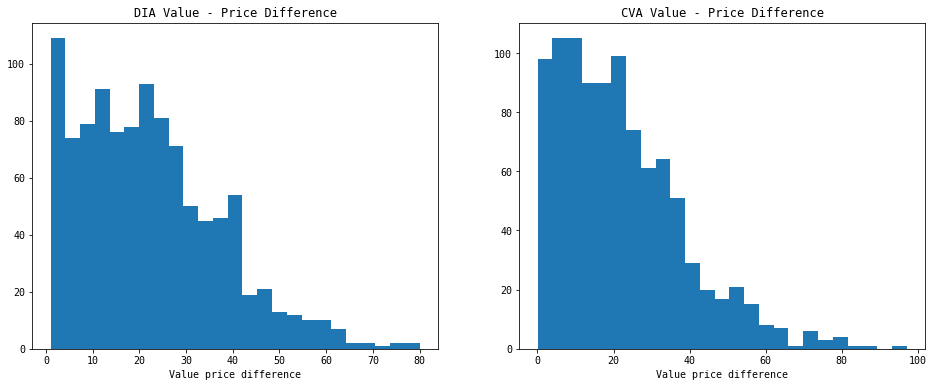

In [10]:
price_diff_fig, (ax_dia_diff, ax_cva_diff) = plt.subplots(1, 2, figsize=(16, 6))

dia_diff = [task['value'] - result['Optimal DIA']['task prices'][task['name']] 
            for result in results_data for task in result['model']['tasks']
            if task['name'] in result['Optimal DIA']['task prices']]
ax_dia_diff.hist(dia_diff, bins=25)
ax_dia_diff.set_xlabel('Value price difference')
ax_dia_diff.set_title('DIA Value - Price Difference')

cva_diff = [task['value'] - result[cva_algo]['task prices'][task['name']] 
            for result in results_data for task in result['model']['tasks']
            if task['name'] in result[cva_algo]['task prices']]
ax_cva_diff.hist(cva_diff, bins=25)
ax_cva_diff.set_xlabel('Value price difference')
ax_cva_diff.set_title('CVA Value - Price Difference')

### Dia comparison

Price change: dict_values([3, 3, 3, 3, 3, 3]), initial price: dict_values([25, 25, 25, 25, 25, 25])


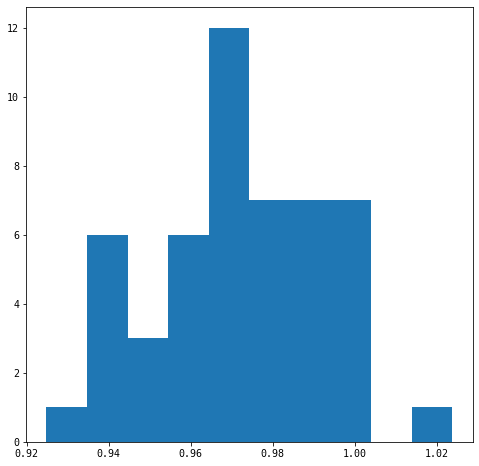

In [44]:
social_welfare_diff = [
    result['Flexible VCG']['social welfare'] / result['Optimal DIA']['social welfare']
    for result in results_data
]

_, ax = plt.subplots(figsize=(8, 8))
ax.hist(social_welfare_diff)

print(f'Price change: {results_data[0]["Optimal DIA"]["price change"].values()}, '
      f'initial price: {results_data[0]["Optimal DIA"]["server initial price"].values()}')

Text(0, 0.5, 'Value')

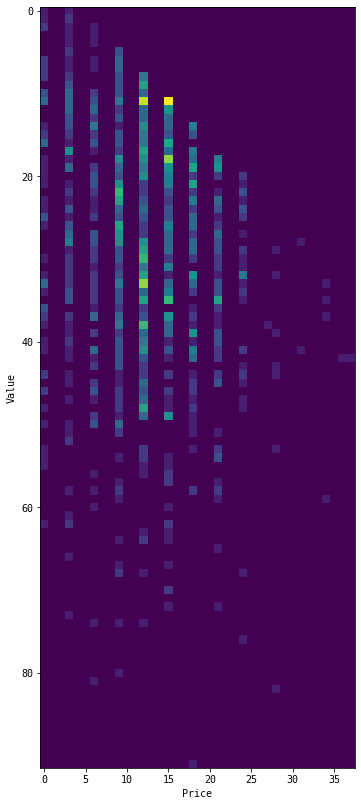

In [34]:
task_value_price = [(task['value'], result['Optimal DIA']['task prices'][task['name']])
                    for result in results_data for task in result['model']['tasks']
                    if task['name'] in result['Optimal DIA']['task prices']]
min_value, max_value = min(value for value, _ in task_value_price), max(value for value, _ in task_value_price)
min_price, max_price = min(price for _, price in task_value_price), max(price for _, price in task_value_price)

_, ax = plt.subplots(figsize=(12, 14))
density = [[task_value_price.count((value, price)) for price in range(min_price, max_price+1)] 
            for value in range(min_value, max_value+1)]
assert sum(sum(d) for d in density) == len(task_value_price), f'{sum(sum(d) for d in density)} {len(task_value_price)}'
ax.imshow(density)
    
ax.set_xlabel('Price')
ax.set_ylabel('Value')

## Overall results

In [35]:
reduced_df = auction_df[(auction_df['name'] == cva_algo) | (auction_df['name'] == 'Flexible VCG') | 
                        (auction_df['name'] == 'Fixed VCG') | (auction_df['name'] == 'Optimal DIA')]
reduced_df = reduced_df.copy()
reduced_df.loc[auction_df['name'] == cva_algo, 'name'] = 'Decentralised Iterative Auction'
reduced_df.loc[auction_df['name'] == 'Optimal DIA', 'name'] = 'Critical Value Auction'
reduced_df

Save file location: figs/auctions/eps/auctions_results.eps
Save file location: figs/auctions/png/auctions_results.png
Save file location: figs/auctions/pdf/auctions_results.pdf


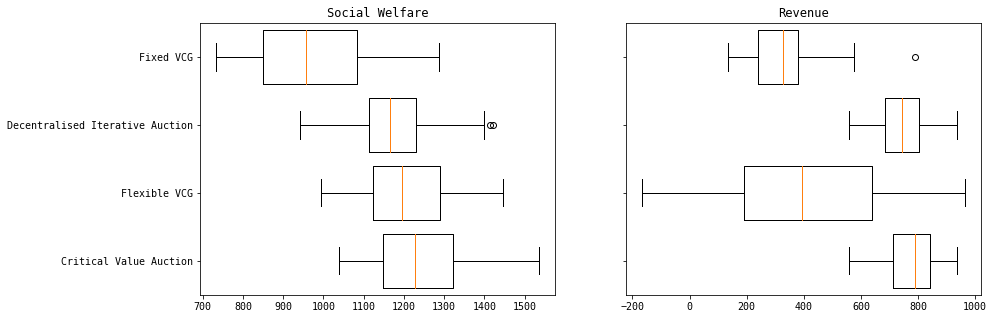

In [37]:
reduced_fig, (ax_reduced_sw, ax_reduced_rev) = plt.subplots(1, 2, figsize=(14,5))
ax_reduced_sw.boxplot(reduced_df['social welfare'], vert=False, widths=0.8)
ax_reduced_sw.set_yticklabels(reduced_df['name'])
ax_reduced_sw.set_title('Social Welfare')

ax_reduced_rev.boxplot(reduced_df['revenue'], vert=False, widths=0.8)
plt.setp(ax_reduced_rev.get_yticklabels(), visible=False)
ax_reduced_rev.set_title('Revenue')
save_plot('auctions_results', 'auctions')